# <center>Инструменты сериализации: `PICKLE`

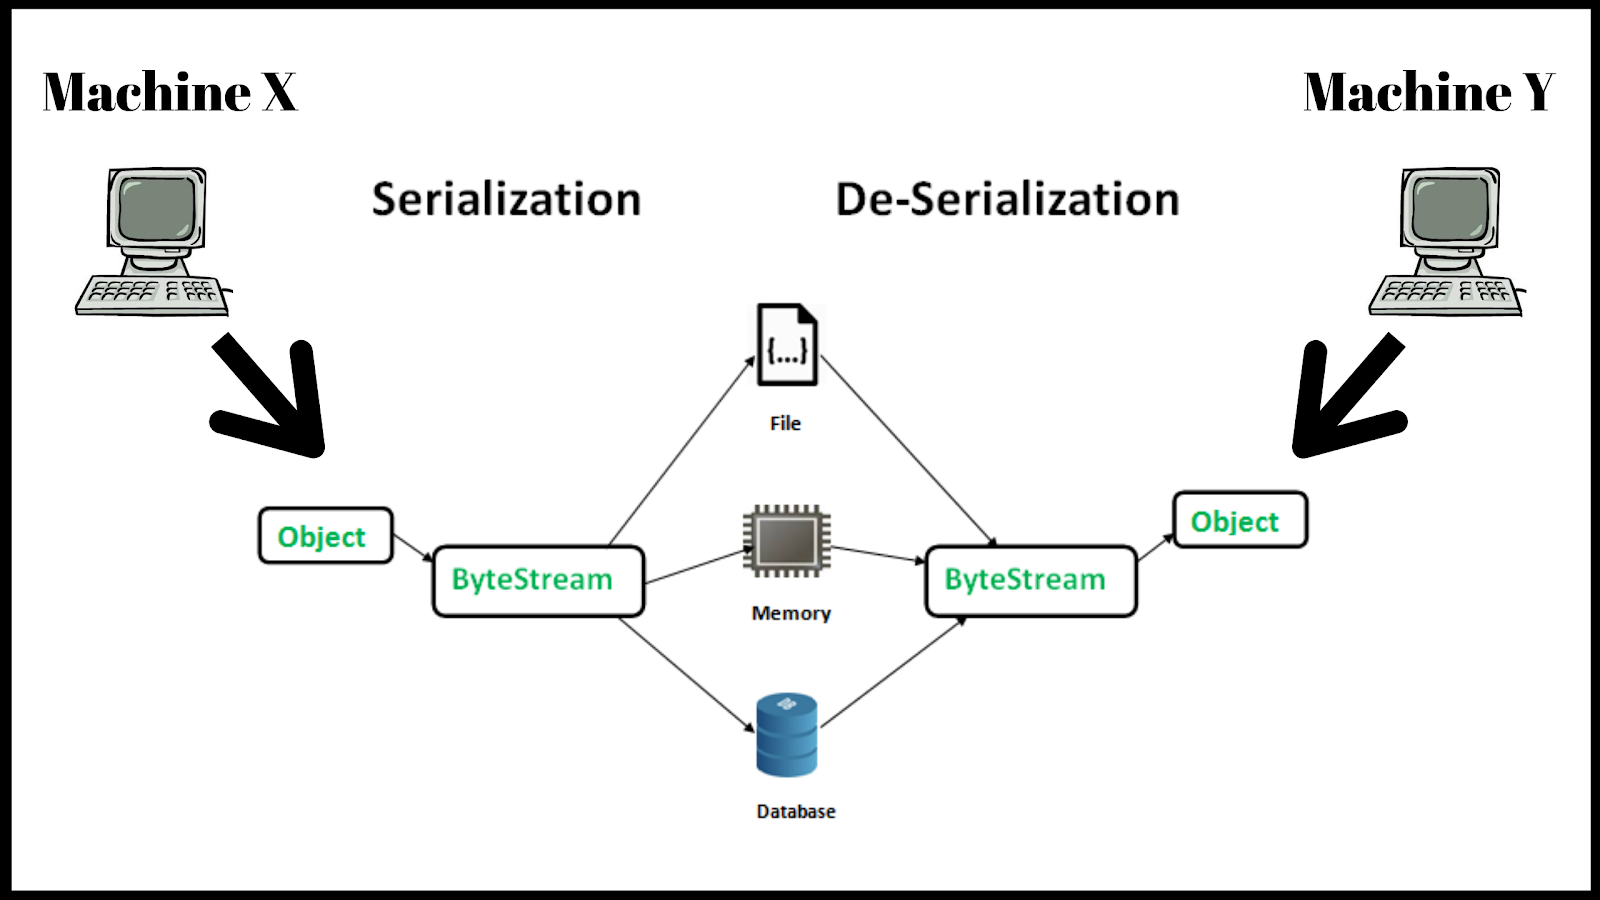

**ШАГ 1**

Обучим модель линейной регрессии на встроенном датасете о диабете — Diabetes dataset.


In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes

# Загружаем датасет о диабете
X, y = load_diabetes(return_X_y=True)
# Инициализируем модель линейной регрессии
regressor = LinearRegression()
# Обучаем модель
regressor.fit(X,y)

## LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

В результате выполнения кода получился объект класса `LinearRegression`, на который ссылается переменная `regressor`. При этом атрибуты объекта (веса модели линейной регрессии) были сформированы во время обучения. То есть объект `regressor` теперь является обученной моделью.

**ШАГ 2**

Далее, когда мы получили обученную модель, нам необходимо сериализовать её, превратив объект *Python* в поток байтов. Для этого импортируем модуль `pickle` и воспользуемся функцией `dumps()`, в которую нужно передать объект *Python*.



In [2]:
import pickle

# Производим сериализацию обученной модели
model = pickle.dumps(regressor)

print(type(model))
print(type(regressor))

<class 'bytes'>
<class 'sklearn.linear_model._base.LinearRegression'>


Как видим, мы создали объект `model` типа `bytes`.

**ШАГ 3**

Давайте попробуем восстановить (десериализовать) объект *Python*. Для этого в модуле `pickle` есть функция `loads()`, в которую нужно передать сериализованный объект (поток байтов).



In [3]:
# Производим десериализацию
regressor_from_bytes = pickle.loads(model)
regressor_from_bytes
## LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

**ШАГ 4**

Сохраним сериализованный объект прямо в файл. Для этого в `pickle` есть функция `dump()` (без `s` на конце). В неё необходимо передать имя файла или ссылку на открытый файл. Файл назовём `myfile`, его расширение — `.pkl` (формат данных `pickle`):



In [4]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('myfile.pkl', 'wb') as output:
    pickle.dump(regressor, output)

Теперь у нас есть бинарный файл с готовой моделью, и мы можем передать его, например, *ML*-инженерам, которые будут заниматься деплоем модели на сервер.

**ШАГ 5**

Посмотрим на код, который восстанавливает (десериализует) обученную модель из файла `myfile.pkl`. Для этого в `pickle` есть функция `load()` (без `s` на конце). В неё необходимо передать имя файла или ссылку на открытый файл.



In [5]:
# Производим десериализацию и извлекаем модель из файла формата pkl
with open('myfile.pkl', 'rb') as pkl_file:
    regressor_from_file = pickle.load(pkl_file)

regressor_from_file

LinearRegression()

**ШАГ 6**

Убедимся, что методы и результаты предсказаний обученной модели и модели, загруженной из файла, совпадают:



In [6]:
# Проверяем, что все элементы массивов предсказаний совпадают между собой
all(regressor.predict(X) == regressor_from_bytes.predict(X))
## True
all(regressor.predict(X) == regressor_from_file.predict(X))
## True

True

Исходная и восстановленная из байтов и файла модели дают одинаковые предсказания. Это значит, что теперь мы можем импортировать наши обученные модели в любое *Python*-приложение и пользоваться ими, минуя этап обучения и все этапы, предшествующие ему.

## <center>Ограничения
Как мы упоминали, у `pickle` есть ограничения. Например, мы не можем сериализовать лямбда-функции.

In [7]:
my_lambda = lambda x: x*2
with open('my_lambda.pkl', 'wb') as output:
    pickle.dump(my_lambda, output)
 
##"PicklingError: Can't pickle <function <lambda>"

PicklingError: Can't pickle <function <lambda> at 0x000002A46DAEE4D0>: attribute lookup <lambda> on __main__ failed

В таких случаях лучше пользоваться пакетом [dill](https://github.com/uqfoundation/dill).



# <center>Сохранение пайплайна

`pickle` работает с любыми объектами *Python*. Поэтому для сохранения может быть доступна не просто обученная модель, но и целый **пайплайн**, включающий предобработку данных.

Например, мы хотим сериализовать пайплайн, который включает в себя *min-max*-нормализацию и отбор пяти наиболее важных факторов на основе корреляции Пирсона. Полученные в результате данные отправляются на вход модели линейной регрессии.



In [8]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Загружаем датасет о диабете
X, y = load_diabetes(return_X_y=True)

# Создаём пайплайн, который включает нормализацию, отбор признаков и обучение модели
pipe = Pipeline([  
  ('Scaling', MinMaxScaler()),
  ('FeatureSelection', SelectKBest(f_regression, k=5)),
  ('Linear', LinearRegression())
  ])

# Обучаем пайплайн
pipe.fit(X, y)

Pipeline(steps=[('Scaling', MinMaxScaler()),
                ('FeatureSelection',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x000002A4211B85E0>)),
                ('Linear', LinearRegression())])

Пайплайн обучен. Давайте сохраним его в файл с помощью `pickle`:



In [9]:
# Сериализуем pipeline и записываем результат в файл
with open('my_pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

Если сериализация завершилась успешно, то при инференсе модели мы сможем восстановить её из файла:



In [10]:
# Десериализуем pipeline из файла
with open('my_pipeline.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

Проверим, что результаты исходного и десериализованного пайплайнов и идентичны:



In [11]:
# Сравниваем предсказания исходного и восстановленного пайплайнов
print(all(pipe.predict(X) == loaded_pipe.predict(X)))

True


Однако в процессе предобработки могут возникнуть шаги, которые нельзя реализовать стандартными методами `sklearn`. Например, для решения многих задач мы часто использовали *feature engineering*, чтобы повысить качество работы моделей. Как встроить этот шаг в исходный пайплайн?

Для этого в `sklearn` можно организовать так называемые кастомные трансформеры. Такой трансформер должен наследоваться от двух классов: `TransformerMixin` и `BaseEstimator`.

У трансформера должно быть **три обязательных метода**:

* `__init__()` — метод, который вызывается при создании объекта данного класса. Он предназначен для инициализации исходных параметров.  
Например, у трансформера для создания полиномиальных признаков `PolynomialFeatures` из `sklearn` в методе `__init__()` параметр `degree` задаёт степень полинома.
* `fit()` — метод, который вызывается для «обучения» трансформера. Он должен возвращать ссылку на сам объект (`self`).  
Например, в трансформере `StandardScaler` в методе `fit()` прописано вычисление среднего значения и стандартного отклонения в каждом столбце таблицы, переданной в качестве параметра метода `fit()`.
* `transform()` — метод, который трансформирует приходящие на вход данные. Он должен возвращать преобразованный массив данных.  
Например, при вызове метода `transform()` у `StandardScaler` из `sklearn` внутри происходит преобразование — вычитание из каждого столбца среднего и деление результата на стандартное отклонение. Причём среднее и стандартное отклонение вычисляются заранее в методе `fit()`.

У некоторых трансформеров из `sklearn`, например у того же `MinMaxScaler`, есть ещё и метод `fit_transform()`, который является комбинацией методов `fit()` и `transform()`.


In [13]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
class MyTransformer(TransformerMixin, BaseEstimator):
    '''Шаблон кастомного трансформера'''
 
    def __init__(self):
        '''
        Здесь прописывается инициализация параметров, не зависящих от данных.
        '''
        pass
 
    def fit(self, X, y=None):
        '''
        Здесь прописывается «обучение» трансформера.
        Вычисляются необходимые для работы трансформера параметры (если они нужны).
        '''

        return self
 
    def transform(self, X):
        '''
        Здесь прописываются действия с данными.
        '''
        return X

Наш трансформер пока что ничего не делает. Предположим, мы хотим генерировать в данных новый признак, который является простым произведением первых трёх столбцов таблицы. Давайте пропишем в методе `transform()` эти действия.

Для работы такого трансформера нужны только исходные данные без дополнительных параметров, поэтому методы `__init__()` и `fit()` остаются без изменений.



In [14]:
class MyTransformer(TransformerMixin, BaseEstimator):
    '''Шаблон кастомного трансформера'''


    def __init__(self):
        '''Здесь прописывается инициализация параметров, не зависящих от данных.'''
        pass


    def fit(self, X, y=None):
        '''
        Здесь прописывается «обучение» трансформера.
        Вычисляются необходимые для работы трансформера параметры (если они нужны).
        '''
        return self


    def transform(self, X):
        '''Здесь прописываются действия с данными.'''
        # Создаём новый столбец как произведение первых трёх
        new_column = X[:, 0] * X[:, 1] * X[:, 2]
        # Для добавления столбца в массив нужно изменить его размер на (n_rows, 1)
        new_column = new_column.reshape(X.shape[0], 1)
        # Добавляем столбец в матрицу измерений
        X = np.append(X, new_column, axis=1)
        return X

Посмотрим, как работает наш кастомный трансформер. Создадим объект трансформера, вызовем метод `transform` и посмотрим на результирующий размер таблицы.



In [15]:
# Инициализируем объект класса MyTransformer (вызывается метод __init__)
custom_transformer = MyTransformer()
# Чисто формально вызываем метод fit, но у нас он ничего не делает
custom_transformer.fit(X)
# Трансформируем исходные данные (вызывается метод transform)
X_transformed = custom_transformer.transform(X)
print('Shape before transform: {}'.format(X.shape))
print('Shape after transform: {}'.format(X_transformed.shape))

Shape before transform: (442, 10)
Shape after transform: (442, 11)


Видно, что в результате трансформации в исходную матрицу наблюдений добавился новый столбец.

Теперь давайте встроим этот трансформер в сам пайплайн — для этого достаточно добавить новый шаг в пайплайн.

In [16]:
# Создаём пайплайн, который включает Feature Engineering, нормализацию, отбор признаков и обучение модели
pipe = Pipeline([  
  ('FeatureEngineering', MyTransformer()),
  ('Scaling', MinMaxScaler()),
  ('FeatureSelection', SelectKBest(f_regression, k=5)),
  ('Linear', LinearRegression())
  ])

# Обучаем пайплайн
pipe.fit(X, y)

Pipeline(steps=[('FeatureEngineering', MyTransformer()),
                ('Scaling', MinMaxScaler()),
                ('FeatureSelection',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x000002A4211B85E0>)),
                ('Linear', LinearRegression())])

Наконец можно сериализовать полученный *pipeline*:

In [17]:
# Сериализуем pipeline и записываем результат в файл
with open('my_new_pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

Теперь мы можем передать пайплайн и воспользоваться им для инференса, предварительно произведя десериализацию.



**Задание 2.5**

Десериализуйте полученный *pipeline* с добавленным в него кастомной трансформации из файла. Затем предскажите значение целевой переменной для наблюдения, которое описывается следующим вектором:

In [18]:
features = np.array([[ 0.00538306, -0.04464164,  0.05954058, -0.05616605,  0.02457414, 0.05286081, -0.04340085,  0.05091436, -0.00421986, -0.03007245]])

with open('my_new_pipeline.pkl', 'rb') as new_pkl:
    new_pipe = pickle.load(new_pkl)

new_pipe.predict(features)

array([173.01985747])

# <center>Библиотека `JOBLIB`

Как мы видим, `pickle` прекрасно справляется со своей задачей: мы можем сериализовать и восстанавливать любые *Python*-объекты, включая модели и даже пайплайны. Однако иногда массивы данных, на которых обучаются модели, бывают настолько большими, что после загрузки из `pickle` невозможно восстановить объект полностью.

В таких случаях вместо `pickle` лучше использовать библиотеку `joblib`. Этот модуль более эффективен и надёжен для работы с объектами, которые содержат большие массивы данных. Пожалуй, единственный минус этого модуля в том, что он может «консервировать» только в файл, поэтому вы не сможете получить объект в виде бинарной строки и работать с ним. В модуле попросту отсутствуют методы для работы с бинарной строкой. Формат файлов для сохранения — `.joblib`.

В остальном работа с `joblib` полностью идентична работе с `pickle`: после обучения модели производим сериализацию с помощью функции `dump()`, а в коде самого приложения, где нужно использовать модель, выполняем десериализацию с помощью функции `load()`. В каждую из этих функций необходимо передать путь до файла для записи и чтения соответственно.



In [19]:
import joblib

# Загружаем датасет о диабете
X, y = load_diabetes(return_X_y=True)
# Обучаем модель линейной регрессии
regressor = LinearRegression()
regressor.fit(X, y)
# Производим сериализацию и сохраняем результат в файл формата .joblib
joblib.dump(regressor, 'regr.joblib')

['regr.joblib']

Загрузим файл заново:



In [20]:
# Десериализуем модель из файла
clf_from_jobliv = joblib.load('regr.joblib') 
# Сравниваем предсказания
all(regressor.predict(X) == clf_from_jobliv.predict(X))

True

# <center>Практика: `pickle`

In [21]:
with open('model.pkl', 'rb') as model_pkl:
    model = pickle.load(model_pkl)
type(model)

secret word: skillfactory
how is this possible? answer is here: https://youtu.be/xm-A-h9QkXg


C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


sklearn.linear_model._base.LinearRegression

Теперь необходимо применить модель. Сделайте предсказание для следующего набора фичей:

In [24]:
features = np.array([[1, 1, 1, 0.661212487096872]])

model.predict(features).round(3)

array([0.666])

У присланной вам модели есть два поля (атрибута) с именами `a` и `b`. Создайте из них словарь с такими же именами ключей и значениями, а затем сохраните его в файл с помощью модуля `pickle`.

In [28]:
attributes_dict = {'a': model.a, 'b': model.b}
with open('attr.pkl', 'wb') as attr_f:
    pickle.dump(attributes_dict, attr_f)

In [29]:
!python hw1_check_ol.py attr.pkl

('secret code 2:', '3c508')


# <center>PREDICTIVE MODEL MARKUP LANGUAGE
Сохраним модель в формат *PMML*.

Рассмотрим пример работы с библиотекой:


In [30]:
from nyoka import skl_to_pmml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)
cols = load_diabetes()['feature_names']

scaler = MinMaxScaler()
pipe = Pipeline([  
            ('Scaling', MinMaxScaler()),
            ('Linear', LinearRegression())
        ])
# Обучение пайплайна, включающего линейную модель и нормализацию признаков
pipe.fit(X, y)
# Сохраним пайплайн в формате pmml в файл pipeline.pmml
skl_to_pmml(pipeline=pipe, col_names=cols, pmml_f_name="pipeline.pmml")

Итак, мы построили пайплайн обработки данных и обучили модель линейной регрессии. После этого мы с помощью функции `skl_to_pmml` сохранили модель в файл `pipe.pmml`.

Давайте рассмотрим этот файл подробнее:

* Секция `<DataDictionary>` содержит информацию о признаках, включая наименование и тип данных, используемых для построения модели.
* Секция `<TransformationDictionary>` содержит информацию о необходимых преобразованиях для каждого признака. Обратите внимание, что в этом блоке также содержится информация для трансформации. Так как мы использовали `minMaxScaler()`, то в файле записаны минимальное и максимальное значения.

В файле содержится вся информация для того, чтобы пайплайн можно было использовать на любом языке программирования.

# <center>ONNX

In [ ]:
import onnxruntime as rt 
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType


# загружаем данные
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)
print(X_train.shape, X_test.shape)

# обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

# делаем инференс моделью на тесте
test_pred = model.predict(X_test)
print('sklearn model predict:\n', test_pred)

# конвертируем модель в ONNX-формат
initial_type = [('float_input', FloatTensorType([None, 13]))]
model_onnx = convert_sklearn(model, initial_types=initial_type)

# сохраняем модель в файл
with open("model.onnx", "wb") as f:
	f.write(model_onnx.SerializeToString())
 	 
# Делаем инференс на тесте через ONNX-runtime
sess = rt.InferenceSession("model.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
test_pred_onnx = sess.run([label_name],
                	{input_name:  X_test.astype(np.float32)})[0].reshape(-1)
print('onnx model predict:\n',test_pred_onnx)